In [6]:
from utils import get_dataframes

dataframes = get_dataframes("", True, False)

In [7]:
characters_liking = dataframes["characters"].loc[:, ["name", "likes", "dislikes"]]
df = characters_liking[characters_liking["likes"].str.len() != 0].reset_index(drop=True)

In [8]:
all_items = set()
for _, row in df.iterrows():
    for i in row["likes"]:
        all_items.add(i)
    for i in row["dislikes"]:
        all_items.add(i)

all_items = list(all_items)
print(f"Found {len(all_items)} unique items.")

Found 264 unique items.


In [9]:
import spacy

nlp = spacy.load("de_core_news_lg")

item_vectors = []
for item in all_items:
    doc = nlp(item)
    item_vectors.append(doc.vector)

import numpy as np

item_vectors = np.array(item_vectors)
print("Vectors shape:", item_vectors.shape)

Vectors shape: (264, 300)


In [18]:
from sklearn.cluster import KMeans

k = 20  # number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(item_vectors)

# kmeans.labels_ is an array of cluster assignments for each item
labels = kmeans.labels_

In [19]:
clusters = {}
for cluster_id in range(k):
    clusters[cluster_id] = []

for item_idx, cluster_id in enumerate(labels):
    clusters[cluster_id].append(all_items[item_idx])

for cluster_id, items_in_cluster in clusters.items():
    print(f"Cluster {cluster_id}: {items_in_cluster}")
    print("---------")


Cluster 0: ['Hunde', 'Katzen']
---------
Cluster 1: ['Entscheidungen', 'Schmerzen', 'Folter', 'Gerichtsprozesse', 'Prüfungen', 'Kontrolle', 'Bestrafungen']
---------
Cluster 2: ['Ruhe', 'Hitze', 'Kälte', 'Sonne', 'Nebel', 'Regen', 'Staub']
---------
Cluster 3: ['Glaube', 'Macht', 'Mut', 'Liebe']
---------
Cluster 4: ['Festivitäten', 'Feiern in Bekanntenkreisen']
---------
Cluster 5: ['Veränderung', 'Spontanität', 'Enttäuschung', 'Einfühlsamkeit', 'Analytisches Denken', 'Arroganz', 'Geselligkeit', 'Unnahbarkeit', 'Unsauberkeit', 'Einsamkeit', 'Eine Belastung sein', 'Übertriebene Ernsthaftigkeit', 'Stärke beweisen', 'Weiblichkeit', 'Stärke', 'Positive Gefühle', 'Selbstständigkeit', 'Aufdringlichkeit', 'Selbstironie', 'Irrationalität', 'Anerkennung', 'Besonnenheit', 'Emotionalität', 'Empathie', 'Respektlosigkeit', 'Aufrichtigkeit', 'Gleichgültigkeit', 'Disziplin', 'Warmherzigkeit', 'Zerstreutheit', 'Minimalismus', 'Unordnung', 'Harmonie', 'Überheblichkeit', 'Ästhetik', 'Teamgeist', 'Taktl

In [20]:
def build_cluster_vector(likes, dislikes, item_to_cluster, num_clusters):
    """
    item_to_cluster: dict mapping item string -> cluster_id
    returns a length `num_clusters` vector with +counts and -counts
    """
    vec = np.zeros(num_clusters, dtype=int)

    for l in likes:
        c = item_to_cluster.get(l, None)
        if c is not None:
            vec[c] += 1

    for d in dislikes:
        c = item_to_cluster.get(d, None)
        if c is not None:
            vec[c] -= 1

    return vec


# Build a dict item -> cluster_id
item_to_cluster = {}
for idx, item in enumerate(all_items):
    cluster_id = labels[idx]
    item_to_cluster[item] = cluster_id

# Now create a vector for each character
character_cluster_vectors = {}
for _, row in df.iterrows():
    name = row["name"]
    likes = row["likes"]
    dislikes = row["dislikes"]
    c_vec = build_cluster_vector(likes, dislikes, item_to_cluster, k)
    character_cluster_vectors[name] = c_vec

# Show an example
for name, vec in character_cluster_vectors.items():
    print(f"{name}: {vec}")


Adamar: [ 1  0  0  0  0  0  0  0  0  0  2  0 -1  0  1  0  0  0  0  0]
Adrian: [ 0  0  0  0  0  0  0  0  1  0  0  2  0 -1  0  1  0  2  0  1]
Alden: [ 0  0  0  0  0  0  0  0  1  0  0  0  0  1  0  0  0 -1  0  1]
Amlin: [ 1  1  2  0 -1 -1  1  0  1  0  0  2  0  0 -1  0  0  2  0  0]
Ar-Merer: [ 0  1  0  1  0  0  0  0  0  0  0 -1  0  0  0  0  0 -1  0  0]
Avila: [ 0  0  0  0  0  1  1  0  0  0  1  1  0 -1  1  0  0  0  0  0]
Burdig: [ 0  0  0  0  1  0  0  0  0  0  2  2  0  0  0  0  0 -1  0  0]
Carmesine: [ 1  0  1  1  0 -1  0  0  0  0  1 -1  0  0 -1  0  0 -1  0  0]
Cordelia: [0 0 0 0 0 1 0 0 0 1 1 2 0 0 0 0 0 0 1 0]
Fubuki: [ 0  0 -1  0  0  0  0  1  1  0  2 -2  0 -1  1  0  0  0  0  0]
Grenze: [ 0  1  0  1  0  2  0  0  0  0  0 -2  0 -2  0  0  0  1  0  0]
Hindrik: [ 0  0  1  0  0  2  0  1  0  0  0  0  0 -1  0  0  0 -1  0  0]
Iddra: [ 1  0  0  1  0 -1  0  0  0  0  3  0  0  1  0  0  0 -1  0  0]
Justicia: [ 0 -1  0  0  0  2  0  0  0  1  0  0  0  0  1  0  0  1  0  0]
Kaen: [ 0  0  0  0  0  0 -1  0  0 

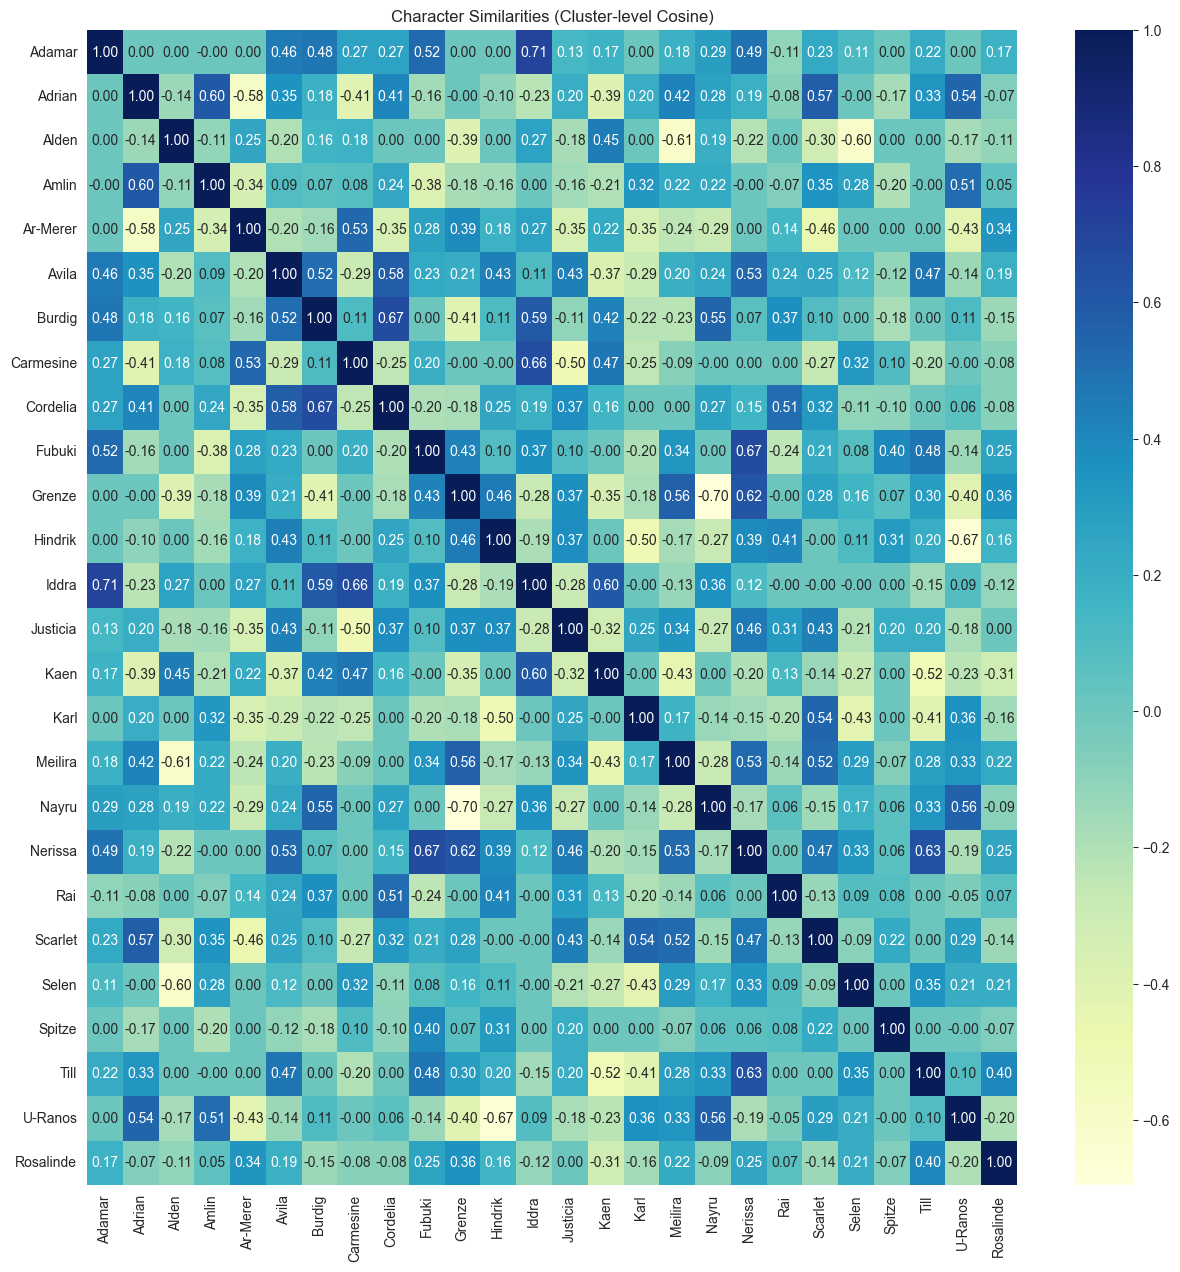

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

names = list(character_cluster_vectors.keys())
vecs = np.array([character_cluster_vectors[n] for n in names])

similarity_matrix = cosine_similarity(vecs)

# Now similarity_matrix[i, j] is the similarity between character i and j
# We can show this in a nice heatmap with Seaborn:

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
sns.heatmap(similarity_matrix,
            xticklabels=names,
            yticklabels=names,
            cmap="YlGnBu",
            annot=True,
            fmt=".2f")
plt.title("Character Similarities (Cluster-level Cosine)")
plt.show()


In [22]:
def character_similarity(char1, char2):
    vec1 = character_cluster_vectors[char1].reshape(1, -1)
    vec2 = character_cluster_vectors[char2].reshape(1, -1)
    return cosine_similarity(vec1, vec2)[0, 0]


selected_characters = ("Hindrik", "Nayru")
print(f"Similarity between {selected_characters[0]} and {selected_characters[1]}:",
      character_similarity(*selected_characters))


Similarity between Hindrik and Nayru: -0.2721655269759086


In [51]:
import numpy as np


def find_most_similar_and_different(target_char, similarity_matrix, names):
    """
    Returns the most similar and the most different character relative to `target_char`,
    based on the provided similarity matrix, ignoring self-comparison.

    :param target_char: Name of the character (string).
    :param similarity_matrix: NxN numpy array of similarity scores.
    :param names: List of character names in the same order as similarity_matrix.
    :return: A tuple (most_similar_name, most_similar_value, most_different_name, most_different_value)
    """
    if target_char not in names:
        raise ValueError(f"{target_char} is not in the list of names.")

    # Find the row index for our target character
    idx = names.index(target_char)
    # Copy the row so we can safely modify it without messing up the original matrix
    sims_copy = similarity_matrix[idx, :].copy()

    # Set the self-similarity to NaN so it won't affect min/max computations
    sims_copy[idx] = float('nan')

    # np.nanargmax / np.nanargmin will ignore NaN entries
    max_idx = np.nanargmax(sims_copy)  # index of highest similarity
    min_idx = np.nanargmin(sims_copy)  # index of lowest similarity

    most_similar_char = names[max_idx]
    most_different_char = names[min_idx]

    max_val = sims_copy[max_idx]  # highest similarity score
    min_val = sims_copy[min_idx]  # lowest similarity score

    return most_similar_char, max_val, most_different_char, min_val


In [52]:
some_char = "Amlin"
most_sim_char, max_val, most_diff_char, min_val = find_most_similar_and_different(
    some_char, similarity_matrix, names
)
print(f"\nFor {some_char}:")
print(f" - Most similar: {most_sim_char} (similarity={max_val:.2f})")
print(f" - Most different: {most_diff_char} (similarity={min_val:.2f})")


For Amlin:
 - Most similar: Justicia (similarity=0.48)
 - Most different: Karl (similarity=-0.57)


In [53]:
#TODO to get the best number of clusters. Test each cluster based on the relationships they have and use the one that maps the relationships the best. For that define a value how positiv or negativ a relationship is.

In [54]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import pandas as pd

df['likes_list'] = df['likes']
df['dislikes_list'] = df['dislikes']

# Extrahiere alle einzigartigen Wörter aus 'likes' und 'dislikes'
all_words = set()
for idx, row in df.iterrows():
    all_words.update(row['likes_list'])
    all_words.update(row['dislikes_list'])
all_words = list(all_words)
print("Einzigartige Wörter:", all_words)

# Berechne die Einbettungen (Embeddings) der Wörter mit einem Sprachmodell
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(all_words)

# Bestimme die Anzahl der Cluster (diesen Wert kannst du anpassen)
num_clusters = 8
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(embeddings)
cluster_labels = kmeans.labels_

# Erstelle ein Mapping von jedem Wort zum zugewiesenen Cluster
word_to_cluster = {word: int(label) for word, label in zip(all_words, cluster_labels)}
print("Mapping der Wörter zu Clustern:", word_to_cluster)


# Funktion zur Berechnung der Cluster-Scores für eine Liste von Wörtern.
# Der Parameter 'sign' ist +1 für Likes und -1 für Dislikes.
def compute_cluster_scores(word_list, sign):
    scores = np.zeros(num_clusters)
    for word in word_list:
        if word in word_to_cluster:
            cluster = word_to_cluster[word]
            scores[cluster] += sign
    return scores


# Berechne für jeden Charakter den Cluster-Score-Vektor:
# Für jedes gelikte Wort wird +1 und für jedes abgelehnte Wort -1 zum entsprechenden Cluster addiert.
df['cluster_scores'] = df.apply(
    lambda row: compute_cluster_scores(row['likes_list'], 1) + compute_cluster_scores(row['dislikes_list'], -1),
    axis=1
)

# Ausgabe der Cluster-Scores pro Charakter
for idx, row in df.iterrows():
    print(f"{row['name']} cluster scores: {row['cluster_scores']}")

# Erstelle eine Kompatibilitätsmatrix basierend auf dem Skalarprodukt der Cluster-Score-Vektoren
names = df['name'].tolist()
compatibility_matrix = pd.DataFrame(index=names, columns=names)

for i in range(len(df)):
    for j in range(len(df)):
        comp_score = np.dot(df.iloc[i]['cluster_scores'], df.iloc[j]['cluster_scores'])
        compatibility_matrix.iloc[i, j] = comp_score

print("\nKompatibilitätsmatrix:")
print(compatibility_matrix)


Einzigartige Wörter: ['Sich blamieren', 'Grün', 'Laute Personen', 'Karl', 'Herzliches Lachen', 'Nachmittagsteerunden', 'Bücher', 'Geistig beschränkte Personen', 'Familie', 'Pöbelnde Personen', 'Übertriebene Ernsthaftigkeit', 'Süßigkeiten', 'Kochen', 'Bedrohliche Personen', 'Imbissbudengerichte', 'Holz', 'Freunde', 'Gefühlsmaskerade', 'Minimalismus', 'Gute Gespräche mit Kunden', 'Voreingenommene Personen', 'Durch Rang erzwungener Respekt', 'Freiluftbäder', 'Sprudelwasser', 'Protokolle', 'Tiere schlachten', 'Weiblichkeit', 'Geschichte', 'Spät aufstehen', 'Saufgelage', 'Höfisches Benehmen', 'Erinnerungen an früher', 'Ungehorsamkeit', 'Grüntee', 'Spontanität', 'Seine Kollegen', 'Süßspeisen', 'Ordnung', 'Hunde', 'Duelle', 'Schwerter', 'Wortwitze', 'Jervar beschützen', 'Gerstentee', 'Kamillentee', 'Macht', 'Kleider', 'Schmieden', 'Hagebuttentee', 'Alleinsein', 'Harmonie', 'Apfelwein', 'Arroganz', 'Trockenes Brot', 'Selbstständigkeit', 'Siegmunds spontane Forderungen', 'Schwarztee', 'Kuscheln

In [76]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline

# -------------------------------
# Daten
# -------------------------------
character_traits = [
    "offen",
    "energetisch",
    "aufdringlich",
    "verspielt",
    "schelmisch",
    "selbstironisch",
    "bodenständig",
    "hilfsbereit",
    "fürsorglich",
    "fröhlich",
    "zugänglich",
    "gerecht",
    "idealistisch",
    "loyal",
    "zielstrebig",
    "dickköpfig",
    "naiv",
    "aufdringlich"
]

other_person1 = {
    "appreciated_traits": [
        "Humorvoll",
        "Selbstironisch",
        "Empathisch",
        "Zurückhaltend",
        "Sarkastisch",
        "Verspielt",
        "Gesellig",
        "Herbstliebend",
        "Genießerisch",
        "Locker",
        "Sinnlich",
        "Warmherzig",
        "Einfühlsam",
        "Spontan"
    ],
    "disliked_traits": [
        "Arrogant",
        "Schlecht gelaunt",
        "Steif",
        "Aufdringlich",
        "Hitze-liebend",
        "Förmlich",
        "Respektlos gegenüber Humor",
        "Sonnenanbeter",
        "Kühl",
        "Selbstverliebt",
        "Unnahbar",
        "Überheblich"
    ]
}

other_person2 = {
    "appreciated_traits": [
        "Strukturiert",
        "Diszipliniert",
        "Selbstständig",
        "Ruhig",
        "Kontrollbewusst",
        "Ordnungsliebend",
        "Nachdenklich",
        "Intellektuell",
        "Mysteriös",
        "Selbstgenügsam",
        "Katzenliebend",
        "Besonnen",
        "Ernsthaft",
        "Analytisch"
    ],
    "disliked_traits": [
        "Faul",
        "Übermäßig emotional",
        "Aufdringlich",
        "Chaotisch",
        "Unstrukturiert",
        "Spontan",
        "Zerstreut",
        "Laut",
        "Überdreht",
        "Feierwütig",
        "Unkontrolliert",
        "Taktlos"
    ]
}


def normalize_list(lst):
    return [s.lower() for s in lst]


character_traits_norm = normalize_list(character_traits)
other1_app = normalize_list(other_person1["appreciated_traits"])
other1_dis = normalize_list(other_person1["disliked_traits"])
other2_app = normalize_list(other_person2["appreciated_traits"])
other2_dis = normalize_list(other_person2["disliked_traits"])

# -------------------------------
# Modelle laden
# -------------------------------
# Embedding-Modell
model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
emb_char = model.encode(character_traits_norm)
emb_other1_app = model.encode(other1_app)
emb_other1_dis = model.encode(other1_dis)
emb_other2_app = model.encode(other2_app)
emb_other2_dis = model.encode(other2_dis)

# Sentiment-Analyse (für Deutsch)
sentiment_analyzer = pipeline("sentiment-analysis", model="oliverguhr/german-sentiment-bert")


def get_sentiment(trait):
    """Gibt einen sentimentalen Score zurück: positive -> +Score, negative -> -Score, neutral -> 0"""
    result = sentiment_analyzer(trait)[0]
    label = result["label"].lower()
    score = result["score"]
    if "positive" in label:
        return score
    elif "negative" in label:
        return -score
    else:
        return 0


# Precompute Sentiments für Charaktereigenschaften
sentiment_char = [get_sentiment(trait) for trait in character_traits_norm]


def sentiment_factor(sent_other, sent_char_value):
    """
    Liefert 1, wenn die Stimmungen übereinstimmen oder einer neutral ist,
    andernfalls -1, falls sie entgegengesetzt sind.
    """
    if sent_other == 0 or sent_char_value == 0:
        return 1
    elif np.sign(sent_other) == np.sign(sent_char_value):
        return 1
    else:
        return -1


# -------------------------------
# Funktionen zur Berechnung der adjustierten Ähnlichkeit
# -------------------------------
def avg_max_adjusted_similarity(emb_source, source_list, emb_target, target_list, sentiment_target):
    """
    Für jedes Trait in source_list wird über alle target_list-Elemente
    der Wert (Cosinus-Ähnlichkeit * Sentiment-Faktor) berechnet.
    Es wird der höchste (adjustierte) Wert genommen und am Ende gemittelt.
    """
    adjusted_sims = []
    for i, src in enumerate(source_list):
        best = -np.inf
        src_emb = emb_source[i]
        src_sent = get_sentiment(src)
        for j, tgt in enumerate(target_list):
            tgt_emb = emb_target[j]
            base_sim = cosine_similarity([src_emb], [tgt_emb])[0][0]
            factor = sentiment_factor(src_sent, sentiment_target[j])
            adjusted = base_sim * factor
            if adjusted > best:
                best = adjusted
        adjusted_sims.append(best)
    return np.mean(adjusted_sims)


def avg_max_adjusted_distance(emb_source, source_list, emb_target, target_list, sentiment_target):
    """
    Für disliked traits: Der Abstand wird als 1 - (max. adjustierte Ähnlichkeit)
    berechnet, und der Durchschnitt dieser Distanzen wird zurückgegeben.
    """
    distances = []
    for i, src in enumerate(source_list):
        best = -np.inf
        src_emb = emb_source[i]
        src_sent = get_sentiment(src)
        for j, tgt in enumerate(target_list):
            tgt_emb = emb_target[j]
            base_sim = cosine_similarity([src_emb], [tgt_emb])[0][0]
            factor = sentiment_factor(src_sent, sentiment_target[j])
            adjusted = base_sim * factor
            if adjusted > best:
                best = adjusted
        distance = 1 - best
        distances.append(distance)
    return np.mean(distances)


# -------------------------------
# Berechnung der Scores
# -------------------------------
# Für Other Person 1:
app_score_1 = avg_max_adjusted_similarity(emb_other1_app, other1_app, emb_char, character_traits_norm, sentiment_char)
dis_distance_1 = avg_max_adjusted_distance(emb_other1_dis, other1_dis, emb_char, character_traits_norm, sentiment_char)
final_score1 = app_score_1 + dis_distance_1 - 1

# Für Other Person 2:
app_score_2 = avg_max_adjusted_similarity(emb_other2_app, other2_app, emb_char, character_traits_norm, sentiment_char)
dis_distance_2 = avg_max_adjusted_distance(emb_other2_dis, other2_dis, emb_char, character_traits_norm, sentiment_char)
final_score2 = app_score_2 + dis_distance_2 - 1

# -------------------------------
# Ausgabe mit Berechnungs-Details
# -------------------------------
print("Other Person 1:")
print("  Appreciated Traits Score: {:.3f}".format(app_score_1))
print("  Disliked Traits Distance: {:.3f}".format(dis_distance_1))
print("  Finaler Score (appreciated - disliked, d.h. app_score + dis_distance - 1): {:.3f}".format(final_score1))
print("  (Berechnung: {:.3f} + {:.3f} - 1 = {:.3f})".format(app_score_1, dis_distance_1, final_score1))

print("\nOther Person 2:")
print("  Appreciated Traits Score: {:.3f}".format(app_score_2))
print("  Disliked Traits Distance: {:.3f}".format(dis_distance_2))
print("  Finaler Score (appreciated - disliked, d.h. app_score + dis_distance - 1): {:.3f}".format(final_score2))
print("  (Berechnung: {:.3f} + {:.3f} - 1 = {:.3f})".format(app_score_2, dis_distance_2, final_score2))


Device set to use cpu


Other Person 1:
  Appreciated Traits Score: 0.738
  Disliked Traits Distance: 0.267
  Finaler Score (appreciated - disliked, d.h. app_score + dis_distance - 1): 0.005
  (Berechnung: 0.738 + 0.267 - 1 = 0.005)

Other Person 2:
  Appreciated Traits Score: 0.661
  Disliked Traits Distance: 0.308
  Finaler Score (appreciated - disliked, d.h. app_score + dis_distance - 1): -0.031
  (Berechnung: 0.661 + 0.308 - 1 = -0.031)


In [77]:
from sentence_transformers import SentenceTransformer, util

# Vortrained Modell laden (multilinguales MiniLM als Beispiel)
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# Beispiel: Person A hat eine Eigenschaft, Person B hat eine Vorliebe und eine Abneigung
eigenschaft = "Alex ist abenteuerlustig."  # Charaktereigenschaft von Person A
vorliebe = "Sam mag abenteuerliche und neugierige Menschen."  # Vorliebe von Person B
abneigung = "Sam mag keine unvorhersehbaren Situationen."  # Abneigung von Person B

# Sätze in den semantischen Vektorraum einbetten
sentences = [eigenschaft, vorliebe, abneigung]
embeddings = model.encode(sentences)

# Kosinus-Ähnlichkeiten berechnen zwischen Eigenschaft und den Aussagen von B
import numpy as np

eig_vec = embeddings[0]
vorliebe_vec = embeddings[1]
abneigung_vec = embeddings[2]

sim_vorliebe = util.cos_sim(eig_vec, vorliebe_vec)
sim_abneigung = util.cos_sim(eig_vec, abneigung_vec)

# Kompatibilität bewerten: bei Abneigung kehren wir das Vorzeichen um
sim_vorliebe = float(sim_vorliebe)  # Ähnlichkeit mit Vorliebe (je höher desto besser)
sim_abneigung = float(sim_abneigung)  # Ähnlichkeit mit etwas, das B nicht mag
compat_abneigung = -sim_abneigung  # je ähnlicher A darin ist, desto schlechter

print("Semantische Ähnlichkeit Eigenschaft vs Vorliebe:", round(sim_vorliebe, 3))
print("Semantische Ähnlichkeit Eigenschaft vs Abneigung:", round(sim_abneigung, 3))
print("Kompatibilit\u00e4tswert Abneigung (invertiert):", round(compat_abneigung, 3))

# Gesamter Kompatibilit\u00e4tsindikator (hier einfach Mittelwert der beiden Aspekte)
gesamt_kompat = (sim_vorliebe + compat_abneigung) / 2
print("Geschätzte Gesamtkompatibilit\u00e4t:", round(gesamt_kompat, 3))


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

C:\Users\Nick Büttner\PycharmProjects\vastlands-exploration\venv\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Nick Büttner\.cache\huggingface\hub\models--sentence-transformers--paraphrase-multilingual-MiniLM-L12-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Semantische Ähnlichkeit Eigenschaft vs Vorliebe: 0.498
Semantische Ähnlichkeit Eigenschaft vs Abneigung: 0.414
Kompatibilitätswert Abneigung (invertiert): -0.414
Geschätzte Gesamtkompatibilität: 0.042


In [78]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Eigenschaften des Charakters
character_traits = [
    "offen",
    "energetisch",
    "aufdringlich",
    "verspielt",
    "schelmisch",
    "selbstironisch",
    "bodenständig",
    "hilfsbereit",
    "fürsorglich",
    "fröhlich",
    "zugänglich",
    "gerecht",
    "idealistisch",
    "loyal",
    "zielstrebig",
    "dickköpfig",
    "naiv",
    "aufdringlich"
]

# Vorlieben und Abneigungen der anderen Person (als JSON-Dictionary)
other_person = {
    "appreciated_traits": [
        "Humorvoll",
        "Selbstironisch",
        "Empathisch",
        "Zurückhaltend",
        "Sarkastisch",
        "Verspielt",
        "Gesellig",
        "Herbstliebend",
        "Genießerisch",
        "Locker",
        "Sinnlich",
        "Warmherzig",
        "Einfühlsam",
        "Spontan"
    ],
    "disliked_traits": [
        "Arrogant",
        "Schlecht gelaunt",
        "Steif",
        "Aufdringlich",
        "Hitze-liebend",
        "Förmlich",
        "Respektlos gegenüber Humor",
        "Sonnenanbeter",
        "Kühl",
        "Selbstverliebt",
        "Unnahbar",
        "Überheblich"
    ]
}

# Normalisierung: Alle Begriffe in Kleinbuchstaben
character_traits_norm = [trait.lower() for trait in character_traits]
appreciated_traits_norm = [trait.lower() for trait in other_person["appreciated_traits"]]
disliked_traits_norm = [trait.lower() for trait in other_person["disliked_traits"]]

# Sätze bilden:
# Für die Charaktereigenschaften: "Die Person ist {trait}."
character_sentences = [f"Die Person ist {trait}." for trait in character_traits_norm]

# Für appreciated traits: "Ich mag Menschen, die {trait} sind."
appreciated_sentences = [f"Ich mag Menschen, die {trait} sind." for trait in appreciated_traits_norm]

# Für disliked traits: "Ich mag keine Menschen, die {trait} sind."
disliked_sentences = [f"Ich mag keine Menschen, die {trait} sind." for trait in disliked_traits_norm]

# Lade ein vortrainiertes Modell (z.B. all-MiniLM-L6-v2)
model = SentenceTransformer('all-MiniLM-L6-v2')

# Berechne Embeddings für die Sätze
emb_char = model.encode(character_sentences)
emb_appreciated = model.encode(appreciated_sentences)
emb_disliked = model.encode(disliked_sentences)


# Berechnet die maximale Kosinus-Ähnlichkeit jedes appreciated trait (in Satzform) zu irgendeinem Charaktertrait.
def avg_max_similarity(emb_source, emb_target):
    """
    emb_source: Embeddings der Sätze (Vorlieben oder Abneigungen)
    emb_target: Embeddings der Charaktereigenschaften-Sätze
    Liefert den Durchschnitt der maximalen Ähnlichkeiten.
    """
    sim_matrix = cosine_similarity(emb_source, emb_target)
    max_sims = sim_matrix.max(axis=1)
    return np.mean(max_sims)


# Durchschnittliche maximale Ähnlichkeit für die (formulierten) Vorlieben
avg_sim_appreciated = avg_max_similarity(emb_appreciated, emb_char)
# Durchschnittliche maximale Ähnlichkeit für die (formulierten) Abneigungen
avg_sim_disliked = avg_max_similarity(emb_disliked, emb_char)

print("Durchschnittliche maximale Ähnlichkeit zu appreciated_traits:", round(avg_sim_appreciated, 3))
print("Durchschnittliche maximale Ähnlichkeit zu disliked_traits:", round(avg_sim_disliked, 3))

# Finaler Kompatibilitätsscore:
# Ein höherer Score bedeutet, dass die Eigenschaften eher zu den Vorlieben passen
# und weniger zu den Abneigungen.
final_score = avg_sim_appreciated - avg_sim_disliked

print("\nFinaler Kompatibilitätsscore (je höher, desto besser):", round(final_score, 3))

# Interpretation:
# - Ein Score nahe +1 deutet darauf hin, dass die Charaktereigenschaften überwiegend den Vorlieben entsprechen.
# - Ein Score nahe -1 deutet darauf hin, dass die Charaktereigenschaften vorwiegend den Abneigungen entsprechen.


Durchschnittliche maximale Ähnlichkeit zu appreciated_traits: 0.555
Durchschnittliche maximale Ähnlichkeit zu disliked_traits: 0.576

Finaler Kompatibilitätsscore (je höher, desto besser): -0.021
